# CS-109: Fall 2015  -- Lab 8

## Apache Spark
![Alt apache spark](img/spark-logo.png)

Apache Spark is an open source cloud computing framework that was original developed in AMPLab at UC Berkley and later donated to Apache Software Foundation. By loading data into cluster's memory's, Spark is able to achieve nearly 100x speed up compared to MapReduce for certain applications.

In [1]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Finding SparkContext

`findspark` library enables ipython notebook to interact with SparkContext 

In [3]:
import findspark
findspark.init() 

import pyspark
sc = pyspark.SparkContext()

### Example: Estimating $\pi$

Let us start by estimating $\pi$ using Monte Carlo simulation with Spark.  

Imagine that we throw 1 million sand particles into a unit square box.  We obtain fraction of particles that land within the area of under $x^2 + y^2$, and after multiplying this fraction by four, we arrive at a rough approximation of $\pi$.

![Alt estimate Pi](img/estimate_pi.gif)

In [7]:
# Function to sample a point
def sample(d):  # Ignore d
    x = np.random.uniform(0,1); y = np.random.uniform(0,1);
    return x*x + y*y < 1.

In [8]:
import time
N = int(10e6)
start = time.time()
total = sc.parallelize(range(N)).map(sample).reduce(lambda a,b: a+b)
print "Pi estimate:", (total / float(N) * 4)
print "Duration: %.5f Seconds" % (time.time() - start)

Pi estimate: 3.1404508
Duration: 11.23119 Seconds


In [6]:
print "Numpy Estimate:", np.pi

Numpy Estimate: 3.14159265359


Our estimate is fairly close to the Numpy's $\pi$.  However, if we increase the number of samples ($N$), we can achieve even greater accuracy at the cost of run time.

### Example: Zipf's Law

Named after the American linguist George Kingsley Zipf (1902-1950), Zipf's Law describes an empirical law that describes the phenomenon in the physical and social sciences where many types of data can be approximated by Zipf distribution - a family of discrete power law probability distributions.

In linguistics, Zipf's law states that given some text of natural language, the frequency of any word is inversely proportional to its rank in the frequency table.  The most frequent word will occur approximately twice as often as the second most frequent word, three times as often as the third most frequent word, etc. 

Zipf's law then predicts that frequency of element of rank $k$ can be approximated by,

$$f(k; s, N) = \frac{1/k^s}{\sum_{n=1}^N (1/n^s)}$$

where $N$ is the number of elements, and $s$ is the value of the exponent characterizing the distribution.  Normally, $s$ is defined to be $1$.

In [9]:
f = lambda rank,elements,s: 1/(np.sum(1./(np.arange(1,elements+1)**s)) * rank**s)

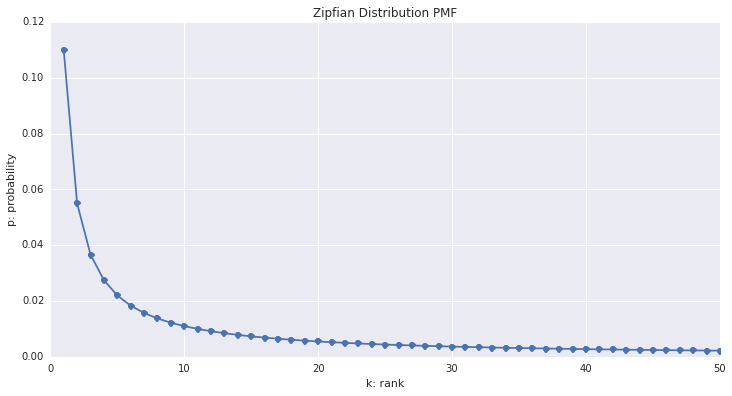

In [10]:
ranks = np.arange(1,51)
N = 5000
s = 1.0

plt.figure(figsize=(12,6))
plt.plot(ranks,f(ranks,N,s), 'o-')
plt.title("Zipfian Distribution PMF")
plt.xlabel("k: rank")
plt.ylabel("p: probability")
plt.show()

Although primarily studied in ranking of words in natural language, Zipf's law has been found to be true in the ranking of cities by population size (Gabaix 1999) and the ranking of US firms (Axtell 2001). 

### wordcount.org

http://www.wordcount.org/main.php

Developed in 2003 by Jonathan Harris, wordcount.org keeps count of over 100 million collection of words from the <a href="http://www.natcorp.ox.ac.uk/">British National Corpus</a> (BNC), which includes spoken and written sources. It keeps track of words that occurs at least twice in the BNC.

<img src="img/wordcountorg.png" width="600px">

### Word Count from Project Gutenberg Texts

In this example, we will attempt to replicate the results from wordcount.org by processing a large volume of sample texts.  We'll use Spark to read the text data, process the texts, and examine the total number of unique words.  

We will sample 16 texts from [Project Gutenberg](https://www.gutenberg.org/ "Title").  We should note that while these texts represent some of the most popular classic English literature, many of them are over 100 years old and therefore may not be representative of lexicon of English language today.

In [8]:
import os
os.listdir('data')

['adventures_of_huckleberry_finn.txt',
 'adventures_of_sherlock_holmes.txt',
 'adventures_of_tom_sawyer.txt',
 'alices_adventures_in_wonderland.txt',
 'autobiography_of_ben_franklin.txt',
 'dracula.txt',
 'emma.txt',
 'frankenstein.txt',
 'great_expectations.txt',
 'iliad.txt',
 'leviathan.txt',
 'moby_dick.txt',
 'peter_pan.txt',
 'pride_and_prejudice.txt',
 'scarlet_letter.txt',
 'tale_of_two_cities.txt']

#### Parsing a String

We'll begin by writing a function that will parse long string of text into individual words.  This function must also eliminate any punctuation marks including "," and ".".  In addition, all the words must be in lowercase characters such that, for example, "Bank" and "bank" are not captured as separate words.

In [9]:
import re

def parsewords(sentence):
    # Convert all non-alphanumeric characters into empty string
    sentence_clean = re.sub(r'([^A-Za-z0-9\s+])', '', sentence)  
    words = sentence_clean.split(' ')
    # Convert to lowercase and eliminate empty string words
    return [word.lower() for word in words if word != ''] 

Let's test out this function using a test string.

In [10]:
sample_sentence = "Alice was beginning to get very tired of sitting by her sister on the \
bank, and of having nothing to do: once or twice she had peeped into the \
book her sister was reading, but it had no pictures or conversations in \
it, 'and what is the use of a book,' thought Alice 'without pictures or \
conversations?'"

In [11]:
parsewords(sample_sentence)[:20]

['alice',
 'was',
 'beginning',
 'to',
 'get',
 'very',
 'tired',
 'of',
 'sitting',
 'by',
 'her',
 'sister',
 'on',
 'the',
 'bank',
 'and',
 'of',
 'having',
 'nothing',
 'to']

#### Load Text Files

Next, we'll load up the text files and create a text file RDD.  Spark provides `textFile` method to read a text file and return it as a RDD.

In [12]:
textsRDD = sc.textFile('data/'+os.listdir('data')[0])
for txt in os.listdir('data')[1:]:
    file_dir = 'data/' + txt
    textRDD = sc.textFile(file_dir)
    textsRDD = textsRDD.union(textRDD)

In [13]:
textsRDD.take(20)

[u'',
 u'',
 u'The Project Gutenberg EBook of Adventures of Huckleberry Finn, Complete',
 u'by Mark Twain (Samuel Clemens)',
 u'',
 u'This eBook is for the use of anyone anywhere at no cost and with almost',
 u'no restrictions whatsoever. You may copy it, give it away or re-use',
 u'it under the terms of the Project Gutenberg License included with this',
 u'eBook or online at www.gutenberg.net',
 u'',
 u'Title: Adventures of Huckleberry Finn, Complete',
 u'',
 u'Author: Mark Twain (Samuel Clemens)',
 u'',
 u'Release Date: August 20, 2006 [EBook #76]',
 u'',
 u'Last Updated: April 18, 2015]',
 u'',
 u'Language: English',
 u'']

We have a a RDD that is a collection of strings.  We'll start by mapping the function `parsewords` to each of the line of strings in `textsRDD`.

In [14]:
textsRDD.map(parsewords).take(5)  # Not quite what we want!

[[],
 [],
 [u'the',
  u'project',
  u'gutenberg',
  u'ebook',
  u'of',
  u'adventures',
  u'of',
  u'huckleberry',
  u'finn',
  u'complete'],
 [u'by', u'mark', u'twain', u'samuel', u'clemens'],
 []]

Unfortunately, the result of mapping `parsewords` to `textsRDD` did not yield the result that we want. 

RDD has `flatMap` method that will map a function that has been passed in as a parameter to elements of the RDD and flatten the result.  We'll use `flatMap` method and apply `parsewords` function to create a new RDD of words. 

In [15]:
wordRDD = textsRDD.flatMap(parsewords)
wordRDD.take(20)

[u'the',
 u'project',
 u'gutenberg',
 u'ebook',
 u'of',
 u'adventures',
 u'of',
 u'huckleberry',
 u'finn',
 u'complete',
 u'by',
 u'mark',
 u'twain',
 u'samuel',
 u'clemens',
 u'this',
 u'ebook',
 u'is',
 u'for',
 u'the']

Now that we have an RDD of words, let's examine how many words are in our sample texts.

In [16]:
# Total Number of Words in our Sample
total_count = wordRDD.count()
print "Total Word Count:", total_count

Total Word Count: 2018318


We will use `map` method of the RDD to convert each occurance of word into a (key,value) pair and create a new RDD called `wordPairRDD`.  If you saw the word count example in MapReduce, you should be familiar with this pattern. 

In [17]:
# Convert individual word into a pair of (word,1) tuple 
wordPairRDD = wordRDD.map(lambda word: (word,1))
wordPairRDD.take(20)

[(u'the', 1),
 (u'project', 1),
 (u'gutenberg', 1),
 (u'ebook', 1),
 (u'of', 1),
 (u'adventures', 1),
 (u'of', 1),
 (u'huckleberry', 1),
 (u'finn', 1),
 (u'complete', 1),
 (u'by', 1),
 (u'mark', 1),
 (u'twain', 1),
 (u'samuel', 1),
 (u'clemens', 1),
 (u'this', 1),
 (u'ebook', 1),
 (u'is', 1),
 (u'for', 1),
 (u'the', 1)]

We have converted wordRDD into a a new RDD that holds each instance of word into a (key,value) pair.  Let's use reduceByKey method to sum up the counts and create a new RDD, `wordCountRDD`. 

In [18]:
wordCountRDD = wordPairRDD.reduceByKey(lambda x,y: x+y)
wordCountRDD.take(20)

[(u'aided', 11),
 (u'fawn', 3),
 (u'disgracewhen', 1),
 (u'wormlike', 1),
 (u'callianira', 1),
 (u'drinkin', 2),
 (u'scufflings', 1),
 (u'jobbing', 1),
 (u'alternating', 6),
 (u'pokers', 1),
 (u'jests', 4),
 (u'em', 209),
 (u'tickets', 20),
 (u'summes', 2),
 (u'enjoy', 90),
 (u'achievements', 5),
 (u'smeared', 7),
 (u'mewith', 1),
 (u'even', 1510),
 (u'observantly', 1)]

In [19]:
# Number of Unique Words
unique_count = wordCountRDD.count()
print "Total Unique Words:", unique_count

Total Unique Words: 56238


Since `wordCountRDD` contains unique words and their counts, we sort them by `takeOrdered` method of RDD specifying the the ordering function to order by the values in (key,value) pairs.  We will only select top 50 words.

In [20]:
# Select Top 50 words in descending order of frequency
top50Words = wordCountRDD.takeOrdered(50, key=lambda x: -x[1]) # Use '-' to sort in descending order
top50Words

[(u'the', 112921),
 (u'and', 70565),
 (u'of', 60234),
 (u'to', 55424),
 (u'a', 39794),
 (u'i', 33960),
 (u'in', 33750),
 (u'that', 27203),
 (u'it', 25073),
 (u'was', 22650),
 (u'he', 22172),
 (u'his', 20604),
 (u'with', 17034),
 (u'as', 16683),
 (u'is', 15833),
 (u'for', 15827),
 (u'you', 15700),
 (u'but', 14447),
 (u'not', 14256),
 (u'be', 13380),
 (u'had', 13236),
 (u'her', 12093),
 (u'at', 11588),
 (u'my', 11345),
 (u'on', 11230),
 (u'by', 10891),
 (u'all', 10465),
 (u'have', 9821),
 (u'him', 9803),
 (u'she', 9718),
 (u'me', 9365),
 (u'so', 9334),
 (u'this', 9273),
 (u'from', 8804),
 (u'or', 8600),
 (u'they', 8569),
 (u'which', 8557),
 (u'no', 7026),
 (u'there', 7007),
 (u'we', 6759),
 (u'were', 6698),
 (u'said', 6646),
 (u'when', 6451),
 (u'if', 6177),
 (u'one', 6137),
 (u'their', 6088),
 (u'are', 5984),
 (u'them', 5749),
 (u'what', 5687),
 (u'would', 5246)]

### Chaining

<img src="img/word_count_RDD_transformation.jpeg" width="600px">

Although we have performed each transformation in separate steps, Spark enables us to perform these four steps in one line of code by chaining them together.

Although Python is strict about indentation, we use a convenient trick of wrapping a chain of RDD methods inside a parenthesis.  This trick enables us to chain multiple RDD methods in several lines of code, which enhances readability of your code. 

In [21]:
top50Words = (textsRDD.flatMap(parsewords)
                      .map(lambda word: (word,1))
                      .reduceByKey(lambda x,y: x+y)
                      .takeOrdered(50, key=lambda x: -x[1]))

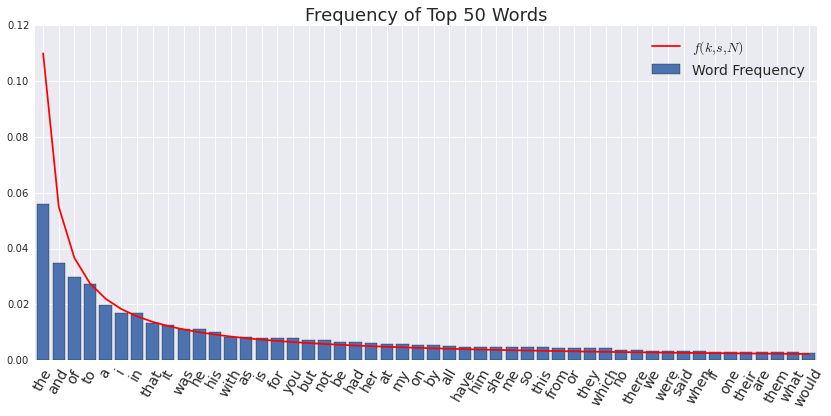

In [22]:
words = list()
counts = list()
for pair in top50Words:
    words.append(pair[0])
    counts.append(pair[1])

plt.figure(figsize=(14,6))
plt.bar(range(1,51), np.array(counts) / float(total_count), label="Word Frequency", align='center')
plt.plot(ranks, f(ranks,N,s), c='r', label="$f(k,s,N)$")
plt.xticks(range(1,51), words[:50], rotation=60, fontsize=14)
plt.title("Frequency of Top 50 Words",fontsize=18)
plt.legend(fontsize=14)
plt.xlim(0.5,50.5)
plt.show()

Although not exact, the word frequency from our sample of texts follows the Zipf distribution closely.  We also see that in our sample texts, "and" is the second most frequently occuring word.  This is in contrast to the word frequency ordering of BNC in which "of" is ranked second and "and" is ranked third.    

For those who are proficient in another language besides English, we encourage you to perform this exercise in another language and share the result with your classmates on Piazza.  

For more examples of Spark in Python, please take a look at various examples in [Apache Spark official github repository](https://github.com/apache/spark/tree/master/examples/src/main/python).  

For detailed discussions about transformations and actions in Spark RDD instance, read through [Apache Spark's official pyspark documentation](http://spark.apache.org/docs/latest/api/python/pyspark.html).